In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import interact, Button
import ipywidgets as widgets
import scipy.ndimage as ndimage

In [2]:
sys.path.insert(1, os.path.join(os.path.join(os.path.abspath(""), os.pardir), os.pardir))
import glutamate_roi_finder as grf
grf.Start_Background()
%matplotlib inline  

In [3]:
print(grf.API_IMG().imgDiffMaxSpatial[158:165])

[ 7  8 55  7  7  8  8]


In [20]:
print(grf.API_IMG().img.shape)
print(grf.API_IMG().imgDiff.shape)

(300, 512, 512)
(299, 512, 512)


[10.48 10.5  10.48 10.95 10.59 10.54 10.56]
[7.79 7.78 7.8  7.88 7.83 7.78 7.82]


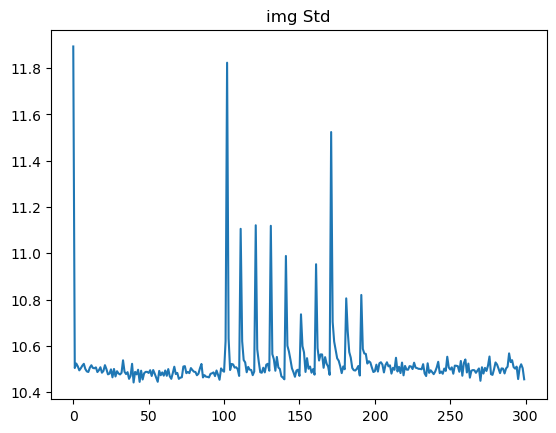

In [42]:
imgStd = np.std(grf.API_IMG().img, axis=(1,2))
imgMean = np.mean(grf.API_IMG().img, axis=(1,2))
print(imgStd[158:165].round(2))
print(imgMean[158:165].round(2))
plt.plot(imgStd)
plt.title("img Std")
plt.show()

[ 7  8 55  7  7  8  8]
[0.62 0.64 1.29 1.13 0.65 0.62 0.66]
[-0.    0.01  0.09 -0.05 -0.04  0.04  0.02]


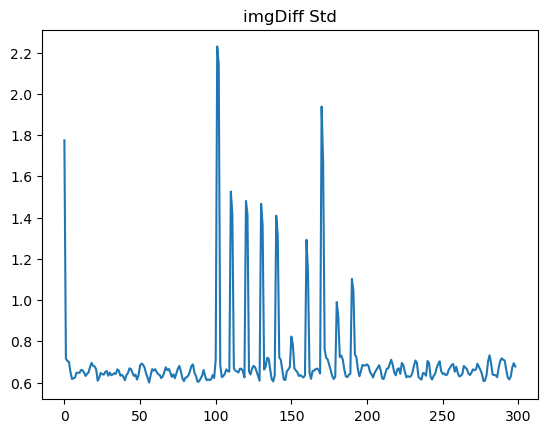

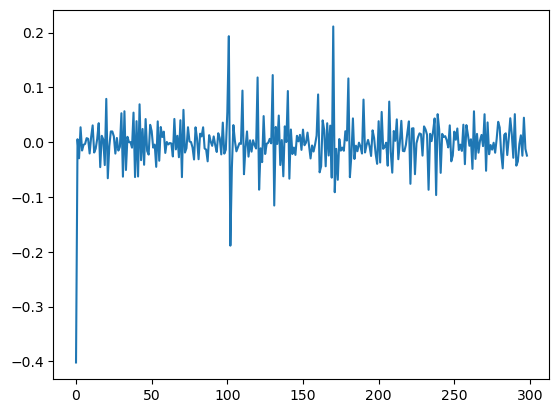

In [49]:
imgDiffStd = np.std(grf.API_IMG().imgDiff, axis=(1,2))
imgDiffMean = np.mean(grf.API_IMG().imgDiff, axis=(1,2))
print(grf.API_IMG().imgDiffMaxSpatial[158:165])
print(imgDiffStd[158:165].round(2))
print(imgDiffMean[158:165].round(2))
plt.plot(imgDiffStd)
plt.title("imgDiff Std")
plt.show()
plt.plot(imgDiffMean)
plt.show()

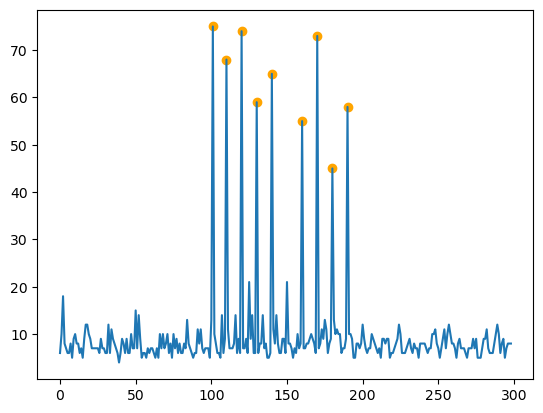

In [4]:
from scipy.signal import find_peaks
def CalcSignalPeaks():
    peaks, props = find_peaks(grf.API_IMG().imgDiffMaxSpatial, prominence=20)
    return peaks

_peaks = CalcSignalPeaks()
#plt.plot(range(100,200), grf.API_IMG().imgDiffMaxSpatial[100:200])
plt.plot(grf.API_IMG().imgDiffMaxSpatial)
plt.scatter(_peaks, grf.API_IMG().imgDiffMaxSpatial[_peaks], c="orange")
plt.show()

In [46]:
_diffMin = np.max(grf.API_IMG().imgDiff)
#_diffMin = np.max(grf.API_IMG().imgDiff[10:90])
def Plot(frame):
    global fig,ax,_diffMin
    fig, ax = plt.subplots()
    ax.imshow(grf.API_IMG().imgDiff[frame], vmin=0, vmax=_diffMin)
    #ax.imshow(grf.API_IMG().imgDiff[frame])
    plt.show()

interact(Plot, frame=widgets.IntSlider(min=0, max=grf.API_IMG().imgDiff.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=298), Output()), _dom_classes=('widget-inter…

<function __main__.Plot(frame)>

In [ ]:
_diffMin = np.max(grf.API_IMG().imgDiff)
_peaks = CalcSignalPeaks()
def Plot(peak):
    global fig,ax,_diffMin,_peaks
    fig, ax = plt.subplots()
    ax.imshow(grf.API_IMG().imgDiff[_peaks[peak]], vmin=0, vmax=_diffMin)
    plt.show()

interact(Plot, peak=widgets.IntSlider(min=0, max=(len(_peaks)-1), step=1, value=0))

In [12]:
_diffMax = np.max(grf.API_IMG().imgDiff)
print(_diffMax)
_peaks = CalcSignalPeaks()
X = np.arange(0,grf.API_IMG().imgDiff.shape[2])
Y = np.arange(0,grf.API_IMG().imgDiff.shape[1])
X, Y = np.meshgrid(X, Y)
def Plot(peak):
    global fig,ax,_diffMax,_peaks, X,Y 
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) 
    ax.axes.set_zlim3d(bottom=0, top=_diffMax) 
    ax.plot_surface(X,Y, grf.API_IMG().imgDiff[_peaks[peak]], cmap=cm.coolwarm, vmin=0, vmax=_diffMax/4)
    ax.set_title(_peaks[peak])
    plt.show()

interact(Plot, peak=widgets.IntSlider(min=0, max=(len(_peaks)-1), step=1, value=0))

21


interactive(children=(IntSlider(value=0, description='peak', max=8), Output()), _dom_classes=('widget-interact…

<function __main__.Plot(peak)>

In [ ]:
#frame0MaxFilter = ndimage.maximum_filter(grf.API_IMG().imgDiff[_peaks[0]], size=(50))
plt.imshow(grf.API_IMG().imgDiff[_peaks[0]], vmin=0, vmax=_diffMin)
plt.plot(frame0LocalMax[:, 1], frame0LocalMax[:, 0], 'r.')
plt.show()

In [ ]:
import skimage.feature as skfeature
frame0LocalMax = skfeature.peak_local_max(grf.API_IMG().imgDiff[_peaks[0]], min_distance=10,threshold_abs=20)
print(len(frame0LocalMax))
print(frame0LocalMax)

In [ ]:
localImages = []
for i in range(len(frame0LocalMax)):
    localMax = frame0LocalMax[i]
    y, x = localMax
    localImages.append(grf.API_IMG().imgDiff[_peaks[0], (y-20):(y+20), (x-20):(x+20)])
    plt.imshow(localImages[i])
    plt.show()

In [ ]:
localMax = frame0LocalMax[0]
y, x = localMax
for i in range(-2,3):
    plt.imshow(grf.API_IMG().imgDiff[_peaks[0]-i, (y-20):(y+20), (x-20):(x+20)])
    plt.show()

1D seitlicher Plot


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
for i in range(len(localImages)):
    locImg = localImages[i]
    locImg1D = np.max(locImg, axis=1)
    axes[i].plot(locImg1D)
    axes[i].set_title(i)
plt.tight_layout()
plt.show()

In [ ]:
axes[1].set_title("")

## Neuer Codes für utils/detection.py

In [69]:
from scipy.signal import find_peaks
import skimage.feature as skfeature

class ROIImage:

    def __init__(self):
        self.signalFrames = None
        self.peaks = None
        self.neurons = None

    def FindSignalFrames(self):
        self.signalFrames, _props = find_peaks(grf.API_IMG().imgDiffMaxSpatial, prominence=20)

    def FindPeaks(self, threshold, distance):
        if (self.signalFrames is None):
            return
        self.peaks = {}
        for frame in self.signalFrames:
            self.peaks[frame] = skfeature.peak_local_max(grf.API_IMG().imgDiff[frame], min_distance=distance,threshold_abs=threshold)
        
        self.neurons = {}
        for frame, peaks in self.peaks.items():
            self.neurons[frame] = self.peaks[frame].copy()
            for i in range(len(peaks)):
                peak = peaks[i]
                x = peak[1]
                y = peak[0]
                X = np.arange(x-20, x+20)
                Y = np.arange(x-20, x+20)
                X, Y = np.meshgrid(X, Y)
                localImg = grf.API_IMG().imgDiff[frame, (y-20):(y+20), (x-20):(x+20)].copy()
                localImg[localImg > 0] = 1
                center_of_mass = ndimage.center_of_mass(localImg)
                self.neurons[frame][i][0] = center_of_mass[0]+y-20
                self.neurons[frame][i][1] = center_of_mass[1]+x-20


roiImage = ROIImage()
roiImage.FindSignalFrames()
roiImage.FindPeaks(15, 15)

In [70]:
print(roiImage.neurons[101])
print(roiImage.peaks[101])

[[131 237]
 [122 430]
 [117 152]
 [153 441]]
[[133 235]
 [122 429]
 [119 154]
 [165 442]]


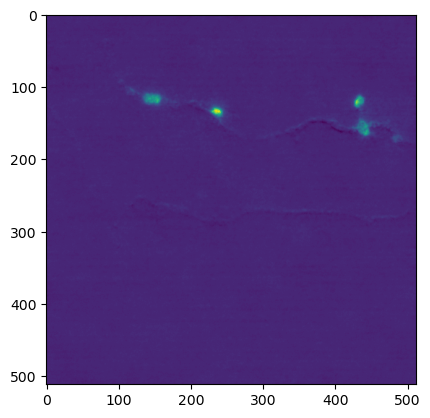

{np.int64(101): array([[131, 237],
       [122, 430],
       [117, 152],
       [153, 441]]), np.int64(110): array([[121, 434],
       [128, 234],
       [137, 445]]), np.int64(120): array([[133, 239],
       [121, 435],
       [168, 486],
       [115, 144]]), np.int64(130): array([[122, 431],
       [118, 139],
       [137, 232],
       [162, 472]]), np.int64(140): array([[130, 241],
       [101, 118],
       [114, 432],
       [114, 142]]), np.int64(160): array([[132, 231],
       [115, 151]]), np.int64(170): array([[132, 238],
       [124, 432],
       [162, 475],
       [ 92, 110],
       [158, 440]]), np.int64(180): array([[120, 433],
       [120, 141],
       [170, 481]]), np.int64(190): array([[130, 236]])}
{np.int64(101): array([[131, 237],
       [122, 430],
       [117, 152],
       [153, 441]]), np.int64(110): array([[121, 434],
       [128, 234],
       [137, 445]]), np.int64(120): array([[133, 239],
       [121, 435],
       [168, 486],
       [115, 144]]), np.int64(130): 

In [52]:
plt.imshow(grf.API_IMG().imgDiff[101])
plt.show()
print(roiImage.peaks)
print(roiImage.neurons)

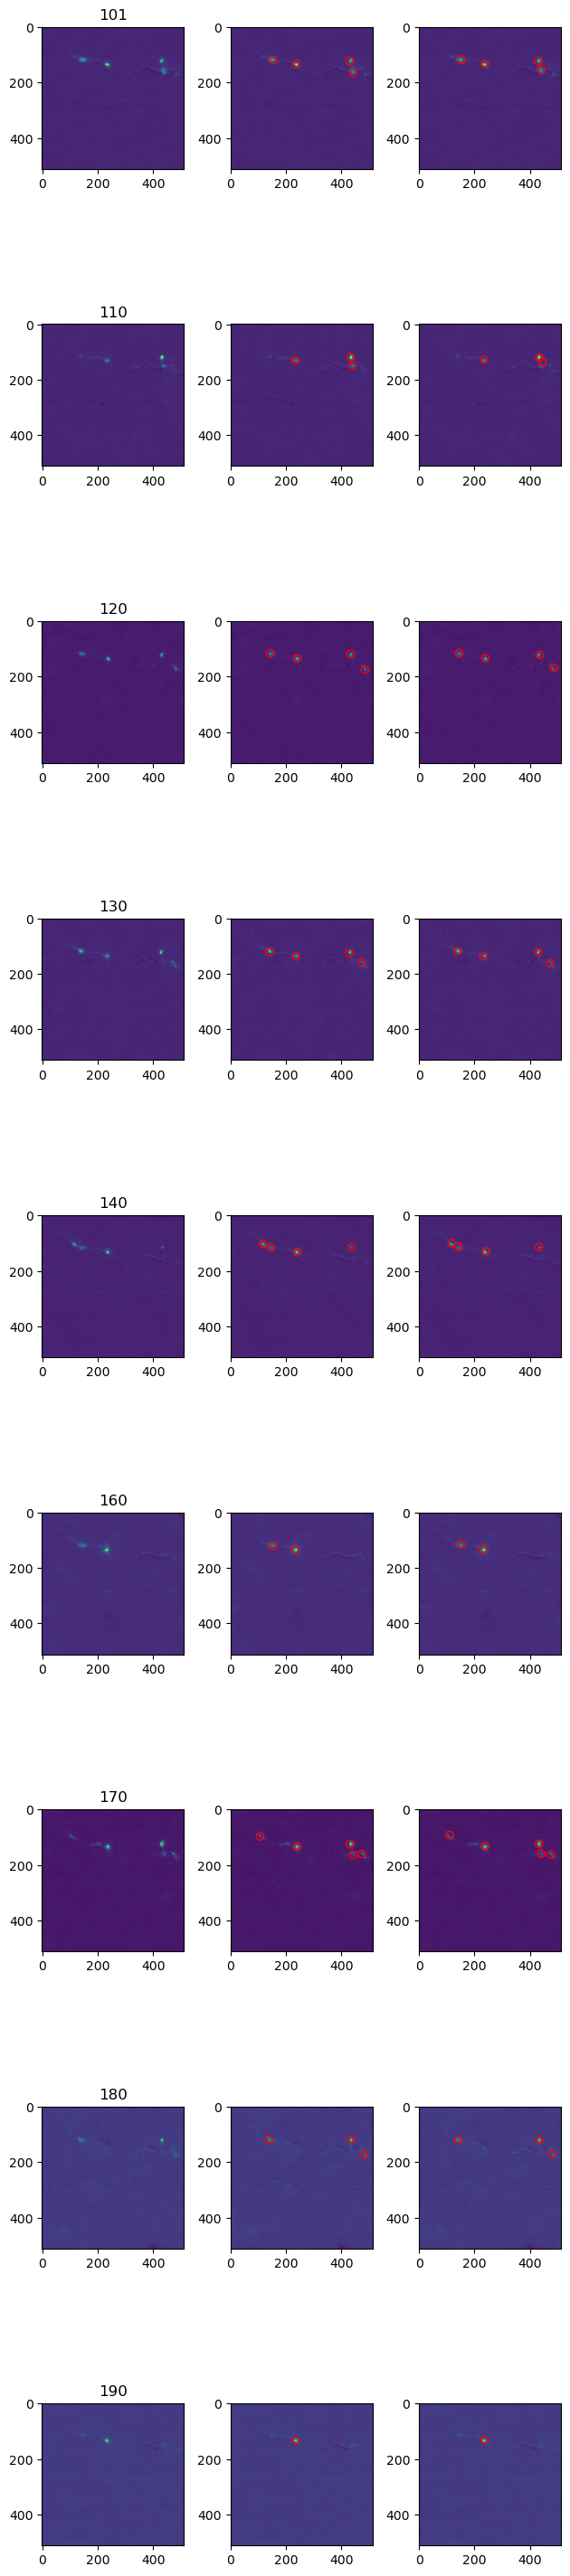

In [71]:
l = len(roiImage.peaks)
fig, axes = plt.subplots(nrows=l, ncols=3)
fig.set_figheight(30)
axes = axes.flatten()
i = 0
for frame,peaks in roiImage.peaks.items():
    neurons = roiImage.neurons[frame]
    axes[3*i].imshow(grf.API_IMG().imgDiff[frame])
    axes[3*i+1].imshow(grf.API_IMG().imgDiff[frame])
    axes[3*i+1].scatter(peaks[:,1], peaks[:,0], facecolors='none', edgecolors='r')
    axes[3*i+2].imshow(grf.API_IMG().imgDiff[frame])
    axes[3*i+2].scatter(neurons[:,1], neurons[:,0], facecolors='none', edgecolors='r')
    axes[3*i].set_title(frame)
    i += 1
plt.tight_layout()
plt.show()

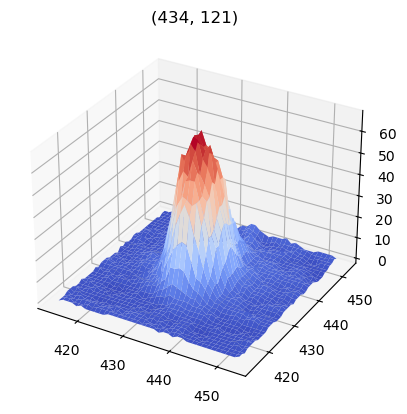

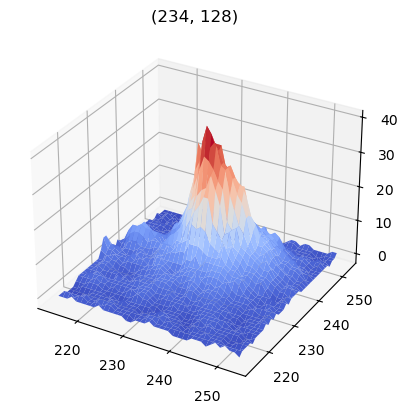

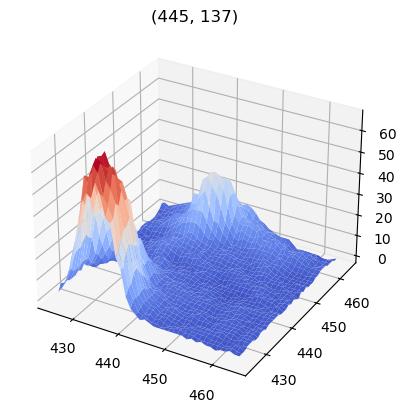

In [73]:
# Arbeite nun mit Peak 3 (frame 120)
_nr = 110
for peak in roiImage.neurons[_nr]:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) 
    x = peak[1]
    y = peak[0]
    X = np.arange(x-20, x+20)
    Y = np.arange(x-20, x+20)
    X, Y = np.meshgrid(X, Y)
    localImg = grf.API_IMG().imgDiff[_nr, (y-20):(y+20), (x-20):(x+20)]
    #plt.imshow(localImg)
    ax.plot_surface(X,Y, localImg, cmap=cm.coolwarm)
    ax.set_title(f"({x}, {y})")
    plt.show()

[4.84785312e-09 5.14711288e-09 5.46375319e-09 ... 6.15666941e-09
 5.80103269e-09 5.46484605e-09]


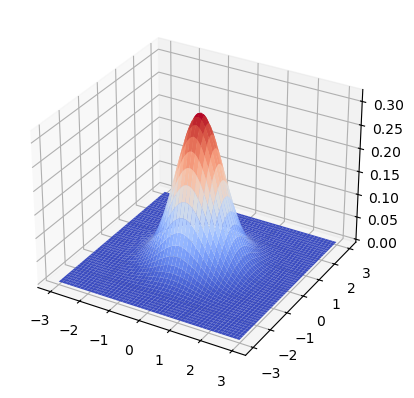

In [133]:
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) 
x, y = np.mgrid[-3:3:0.01, -3:3:0.01]
xy = np.column_stack([x.flat, y.flat])
Z = multivariate_normal.pdf(xy, mean=[0,0], cov=[0.5,0.5])
print(Z)
Z = Z.reshape(x.shape)
ax.plot_surface(x,y, Z, cmap=cm.coolwarm)
plt.show()

    area  moments_weighted-0-0  moments_weighted-0-1  moments_weighted-0-2  \
0  510.0                9440.0              158950.0             3028148.0   

   moments_weighted-0-3  moments_weighted-1-0  moments_weighted-1-1  \
0            63066352.0              113472.0             1932800.0   

   moments_weighted-1-2  moments_weighted-1-3  moments_weighted-2-0  \
0            36583498.0           743422928.0             1687506.0   

   moments_weighted-2-1  moments_weighted-2-2  moments_weighted-2-3  \
0            29241562.0           553287112.0          1.109821e+10   

   moments_weighted-3-0  moments_weighted-3-1  moments_weighted-3-2  \
0            27996330.0           494406782.0          9.400970e+09   

   moments_weighted-3-3  
0          1.879819e+11  


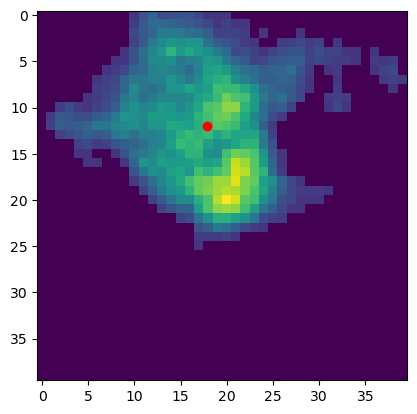

In [163]:
from skimage.measure import regionprops_table
import pandas as pd  

_localImg = localImg.copy()
_localImg[_localImg < 7] = 0
_localImgLabel = _localImg.copy()
_localImgLabel[_localImgLabel > 0] = 1
center_of_mass = ndimage.center_of_mass(_localImg)
regprops = regionprops_table(_localImgLabel, localImg, properties=["area","moments_weighted"])
data = pd.DataFrame(regprops) 
print(data)
plt.imshow(_localImg)
plt.scatter(center_of_mass[1], center_of_mass[0], c="red")
plt.show()

In [135]:
from scipy.optimize import curve_fit


def _Gaussian2d(X, amplitude, meanX, meanY, stdX, stdY):
    pass

def Gaussian2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def FitGaussian2D(img):
    X = np.arange(0, img.shape[1])
    Y = np.arange(0, img.shape[1])
    curve_fit(Gaussian2d, (X, Y), img)

FitGaussian2D(localImg)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.